In [1]:
import tensorflow as tf

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [2]:
image_size = (235, 235)
batch_size = 36

train_gen = data_gen.flow_from_directory('train3', target_size=image_size, batch_size=batch_size) # class_mode default categorical
test_gen = data_gen.flow_from_directory('test3', target_size=image_size, batch_size=batch_size)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [3]:
print(train_gen.class_indices)

{'baklava': 0, 'carrot_cake': 1, 'cheesecake': 2}


### Using InceptionV3
- best one compared to VGG16 and MobileNetV2

In [4]:
image_shape = (235, 235, 3)

In [5]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False) # include top freeze weights

In [6]:
inception_model.trainable=False # don't retrain weights - transfer

### Model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

modelIN = Sequential()
modelIN.add(inception_model)
modelIN.add(Conv2D(32, 3, activation='relu'))  #filters=32, strides=2, kernel_size=(5,5),
modelIN.add(Dropout(0.2))
modelIN.add(GlobalAveragePooling2D()) # avg output of feature map
modelIN.add(Dense(3, activation='softmax'))

modelIN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 4, 4, 32)          589856    
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 22,392,739
Trainable params: 589,955
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
modelIN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(min_delta=0.001, patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_inception.h5', verbose=1, save_best_only=True, save_weights_only=True)

In [11]:
historyIN = modelIN.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - 110s 2s/step - loss: 1.3932 - accuracy: 0.4791 - val_loss: 0.8635 - val_accuracy: 0.5533

Epoch 00001: val_loss improved from inf to 0.86347, saving model to model_inception.h5
Epoch 2/30
63/63 [==============================] - 57s 904ms/step - loss: 0.8076 - accuracy: 0.5729 - val_loss: 0.7334 - val_accuracy: 0.6227

Epoch 00002: val_loss improved from 0.86347 to 0.73344, saving model to model_inception.h5
Epoch 3/30
63/63 [==============================] - 49s 782ms/step - loss: 0.6869 - accuracy: 0.6547 - val_loss: 0.6707 - val_accuracy: 0.7227

Epoch 00003: val_loss improved from 0.73344 to 0.67068, saving model to model_inception.h5
Epoch 4/30
63/63 [==============================] - 49s 779ms/step - loss: 0.6117 - accuracy: 0.7560 - val_loss: 0.6621 - val_accuracy: 0.7733

Epoch 00004: val_loss improved from 0.67068 to 0.66212, saving model to model_inception.h5
Epoch 5/30
63/63 [==============================] - 49s 786ms/step

### Plot Accuracy and Loss

<AxesSubplot:>

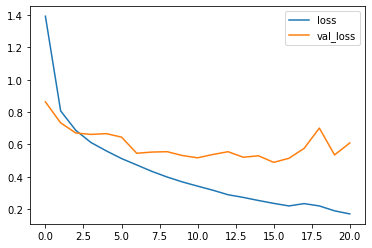

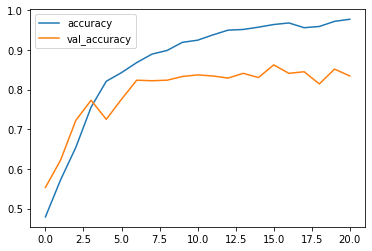

In [12]:
import pandas as pd

history_df = pd.DataFrame(historyIN.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

### Save Model

In [14]:
modelIN.save("models/modelIN_threefeatures.h5")

In [20]:
import os

In [22]:
%cd models
%ls

[WinError 2] The system cannot find the file specified: 'models'
C:\Users\ariel\OneDrive\Anaconda\Hackathons\Hack the North\calorme\AI\models
 Volume in drive C is evo-sys
 Volume Serial Number is 16BD-942A

 Directory of C:\Users\ariel\OneDrive\Anaconda\Hackathons\Hack the North\calorme\AI\models

2021-09-18  01:46 PM    <DIR>          .
2021-09-18  01:46 PM    <DIR>          ..
2021-09-18  01:46 PM        94,807,688 modelIN_threefeatures.h5
               1 File(s)     94,807,688 bytes
               2 Dir(s)  730,466,426,880 bytes free


### Convert to tf lite

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(modelIN)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ariel\AppData\Local\Temp\tmplf44hqqa\assets


### Save as tf lite model

In [37]:
with open('modelIN_threefeatures.tflite', 'wb') as f:
  f.write(tflite_model)